In [22]:
import importlib
import utils
from utils import *
importlib.reload(utils)
from utils import *

False


'\nfrom now on, we operate on xtrain_tr_filled -- shape (5117, 7500)\n'

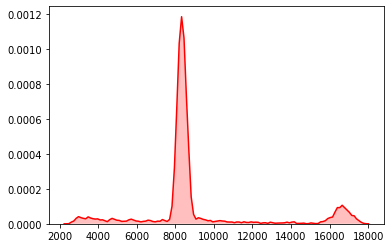

In [23]:
'''
loading data and initial pre-processing
'''

xtrain, xtest, ytrain = load_data()

'''
for each row in xtrain, find indices of last non NaN values
'''
#renaming columns into 0,1,2,...
xtrain = xtrain.rename(columns={x:y for x,y in zip(xtrain.columns,range(0,len(xtrain.columns)))})

'''
last_valid_idx contains the column index for last non-NaN value in the rows of xtrain
'''
last_valid_idx = []

for i in range(0,xtrain.shape[0]):
    row = xtrain.iloc[i,:]
    idx = row.last_valid_index()
    last_valid_idx = np.append(last_valid_idx, idx)
    
'''
plotting kernel density of last_valid_idx
'''
ax = sb.kdeplot(last_valid_idx, shade=True, color="r")

'''
from the kernel density plot, we notice that the majority of series 
starts to show NaN's after the ~7500 index point. We will then first 
attempt classification by truncating all the series at the 7500
column. We will then pad the series which present NaNs before the 7500
columns with the median of the other series. This is just a first trial.
'''

'''
truncate xtrain at 7500 columns -- this prevents us from wasting too much data in truncating
'''
#note to self: load_data() reshiffles the data
xtrain_tr = xtrain.iloc[:,0:7500]


'''
pad shorter series
'''

#consider all rows of xtrain_tr with no NaN's
#Note: we only need to drop all rows with NaN at the last column entry 

#entry i is True if entry is last column in row i of xtrain_tr is NaN 
is_nan = np.isnan(xtrain_tr.iloc[:,-1].values) 
xtrain_tr1 = xtrain_tr[is_nan == False]  #shape = (4565, 7500)
xtrain_tr2 = xtrain_tr[is_nan == True]

#calculate column medians 
medians = np.array(xtrain_tr1.median(axis=0))

for j in xtrain_tr2.columns:
    xtrain_tr2.iloc[:,j] = xtrain_tr2.iloc[:,j].fillna(value = medians[j], axis = 0)
#   print(j)

xtrain_tr_filled = pd.concat([xtrain_tr1, xtrain_tr2])

'''
final dataset: xtrain_tr_filled
dimension: (5117, 7500)
shorter series padded
'''

print(xtrain_tr_filled.isnull().values.any())

'''
from now on, we operate on xtrain_tr_filled -- shape (5117, 7500)
'''

In [24]:
'''
create train, validation, test splits
xtrain_nn, xval_nn, xtest_nn

'''
xtrain_provisional_hb, xtest_hb, ytrain_provisional_hb, ytest_hb = train_test_split(xtrain_tr_filled, 
                                                          ytrain, test_size=0.2, random_state=42)

xtrain_hb, xval_hb, ytrain_hb, yval_hb = train_test_split(xtrain_provisional_hb,   # test set = val set 
                                                          ytrain_provisional_hb, test_size=0.45, random_state=42)

'''
use now: xtrain_hb, xval_hb, xtest_hb, ytrain_hb, yval_hb, xtest_hb, ytest_hb
'''

'\nuse now: xtrain_hb, xval_hb, xtest_hb, ytrain_hb, yval_hb, xtest_hb, ytest_hb\n'

In [27]:
'''
save originals in case you screw up
'''

xtrain_hb_orig = xtrain_hb
ytrain_hb_orig = ytrain_hb
xval_hb_orig = xval_hb
yval_hb_orig = yval_hb
xtest_hb_orig = xtest_hb
ytest_hb_orig = xtest_hb

# Extracting Heartbeats 

In [262]:
import biosppy.signals.ecg as bs_ecg

xtrain_hb = np.array(xtrain_hb)

templates_array = []

for i in range(xtrain_hb.shape[0]):
    beats_info = bs_ecg.ecg(signal= xtrain_hb[i,:], sampling_rate=300, show=False)
    templates_beats = beats_info['templates']
    templates_array.append(templates_beats)

'''
rpeaks_array = []

for i in range(xtrain_hb.shape[0]):
    rpeaks = np.array(bs_ecg.hamilton_segmenter(xtrain_hb[i,:], sampling_rate=300.0))
    rpeaks = rpeaks.flatten()
    rpeaks_array.append(rpeaks)
    
    
rbeats_array = []

for i in range(xtrain_hb.shape[0]):
    rbeats = bs_ecg.extract_heartbeats(signal = xtrain_hb[i,:], 
                rpeaks = rpeaks_array[i], sampling_rate= 300)
    rbeats_array.append(rbeats[0].flatten())

'''

'\nrpeaks_array = []\n\nfor i in range(xtrain_hb.shape[0]):\n    rpeaks = np.array(bs_ecg.hamilton_segmenter(xtrain_hb[i,:], sampling_rate=300.0))\n    rpeaks = rpeaks.flatten()\n    rpeaks_array.append(rpeaks)\n    \n    \nrbeats_array = []\n\nfor i in range(xtrain_hb.shape[0]):\n    rbeats = bs_ecg.extract_heartbeats(signal = xtrain_hb[i,:], \n                rpeaks = rpeaks_array[i], sampling_rate= 300)\n    rbeats_array.append(rbeats[0].flatten())\n\n'

In [303]:
templates_array

[array([[-20.57763083, -18.14050454, -14.44535199, ...,   4.69267602,
           4.75235816,   4.29014319],
        [ -8.53652478,   0.80786024,   6.84888472, ...,   7.87935931,
           4.04577165,   1.51960432],
        [-19.36054019, -18.36773033, -17.92265788, ...,  10.87685399,
          15.96237995,  22.04759456],
        ...,
        [ 43.44490702,  49.77507336,  52.9455831 , ..., -22.48059208,
         -22.65834287, -21.30108832],
        [-20.84112124, -22.46886414, -24.85798097, ..., -24.2034618 ,
         -23.29483939, -20.04388538],
        [-15.06341826, -15.03744324, -13.38288604, ...,  25.43945989,
          23.70654925,  22.10133906]]),
 array([[-20.89698076, -20.46872873, -20.4896531 , ..., -16.23882694,
         -15.70601502, -17.94001725],
        [ 13.78096501,   5.1641538 ,  -3.0392048 , ..., -27.36176186,
         -23.12056723, -17.03536035],
        [ 19.99621037,  23.28407653,  24.15851452, ..., -42.14895295,
         -43.35390352, -42.63253065],
        ...,


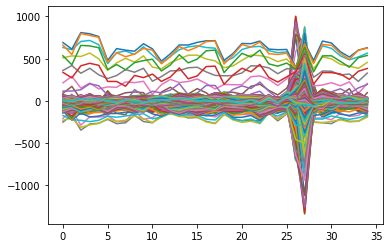

In [298]:
plt.plot(templates_array[0])